d = 
  (columns 0 through 3)
    -0.49895    -2.00000    -4.50000    -8.00000
d = 
  (columns 0 through 3)
     1.00171     0.71726     0.55566     0.42398
mu = 
  (columns 0 through 3)
    -0.01707     3.32323     5.87595     8.58078
mu_shifted = 
  (columns 0 through 3)
    -8.01707    -4.67677    -2.12405     0.58078


NameError: name 'mat' is not defined

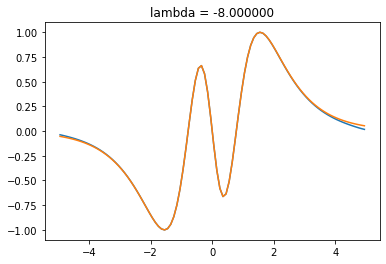

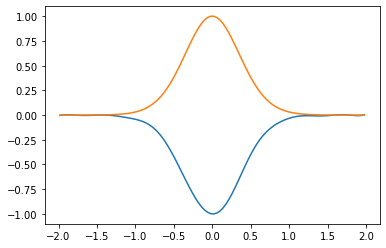

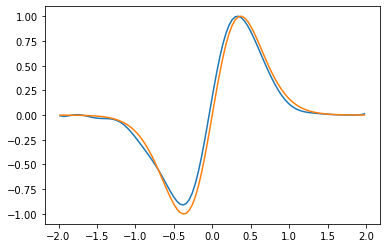

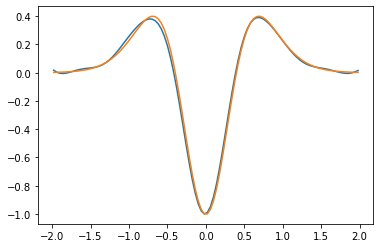

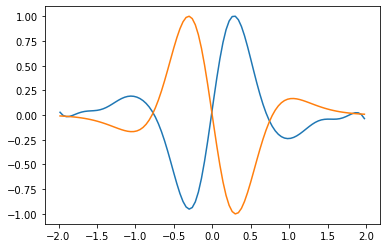

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # noqa: F401 unused import

from addPath import *
addPath()

from d3s import domain
from d3s import kernels
from d3s import algorithms
from d3s import systems
from d3s import observables

from d3s.tools import printVector, printMatrix

plt.ion()

#%% Poeschl-Teller --------------------------------------------------------------------------------

#%% define domain
bounds = np.array([[-5, 5]])
boxes = np.array([100])
Omega = domain.discretization(bounds, boxes)

#%% define system
h  = 1
m0 = 1
s = 4

sech = lambda x : 1 / np.cosh(x)

def c0(x):
    return -h**2/(2*m0)*s*(s+1)*sech(x)**2

def c2(x):
    return -h**2/(2*m0)

#%% analytically computed eigenfunctions fors = 4
psi = (lambda x : sech(x)**4,
       lambda x : sech(x)**3*np.tanh(x),
       lambda x : sech(x)**2*(7*np.tanh(x)**2 - 1),
       lambda x : sech(x)*np.tanh(x)*(7*np.tanh(x)**2 - 3))

#%% generate data
m = 100
X = Omega.rand(m)

#%% define kernel
k = kernels.gaussianKernel(0.3)

#%% apply kernel generator EDMD
evs = 4
G_00 = kernels.gramian(X, k)
G_10 = np.zeros((m , m))
for i in range(m):
    for j in range(m):
        G_10[i, j] = c0(X[:, i]) * k(X[:, i], X[:, j]) + np.sum( c2(X[:, i]) * k.ddiff(X[:, i], X[:, j]), axis=(0,1) )

A, _, _, _ = np.linalg.lstsq(G_00, G_10, rcond=1e-12)
d, V = algorithms.sortEig(A, evs=evs, which='SR')

c = Omega.midpointGrid()
W = kernels.gramian2(c, X, k) @ V

#%% plot spectrum
plt.figure()
plt.plot(np.real(d), '.')
plt.title('Spectrum')

printVector(np.real(d), 'd')

#%% plot eigenfunctions
for i in range(evs):
    plt.figure()
    j = evs-i-1
    Omega.plot(np.real(W[:, j]/np.amax(abs(W[:, j]))))
    
    wa = psi[i](c)
    wa = wa/np.amax(abs(wa))
    plt.plot(c.T, wa.T)
    
    plt.title('lambda = %f' % np.real(d[i]))

#%% Poeschl-Teller potential as SDE ---------------------------------------------------------------

#%% define domain
bounds = np.array([[-2, 2]])
boxes = np.array([100])
Omega = domain.discretization(bounds, boxes)

#% % define system
h = 1e-3
nSteps = 100
tau = nSteps*h
f = systems.PoeschlTeller(h, nSteps)

#% % generate training data
X = Omega.randPerBox(100)
Y = f(X)

#% % Ulam for Koopman
# phi = observables.monomials(10)
# K, d, V = algorithms.edmd(X, Y, phi, evs)

c = Omega.midpointGrid()
# W = V.T @ phi(c)

# printVector(np.real(d), 'd')

# mu = -np.log(d)/tau
# printVector(np.real(mu), 'mu')

# E0 = -8
# printVector(np.real(mu)+E0, 'mu_shifted')

#% % plot eigenfunctions and eigenfunctions multiplied by ground state
# for i in range(evs):
#     plt.figure(i+1)
#     plt.clf()
#     w = np.real(W[i, :])
#     w = w/np.amax(abs(w))
#     Omega.plot(w)
    
#     wa = psi[i](c)/psi[0](c)
#     wa = wa/np.amax(abs(wa))
#     plt.plot(c.T, wa.T)

# for i in range(evs):
#     plt.figure()
#     w = np.real(W[i, :])*np.squeeze(psi[0](c))
#     w = w/np.amax(abs(w))
#     Omega.plot(w)
    
#     wa = psi[i](c)
#     wa = wa/np.amax(abs(wa))
#     plt.plot(c.T, wa.T)

#% % Ulam for Perron-Frobenius
phi = observables.gaussians(Omega, 0.5)
P, d, V = algorithms.edmd(X, Y, phi, evs, operator='P')

W = V.T @ phi(c)

printVector(np.real(d), 'd')

mu = -np.log(d)/tau
printVector(np.real(mu), 'mu')

E0 = -8
printVector(np.real(mu)+E0, 'mu_shifted')

#%% plot eigenfunctions
beta = 2
mu = np.exp(2*s*np.log(sech(c)))
for i in range(evs):
    plt.figure(i+1)
    plt.clf()
    w = np.real(W[i, :])
    w = w/np.amax(abs(w))
    Omega.plot(w)
    
    wa = psi[i](c)*mu/psi[0](c)
    wa = wa/np.amax(abs(wa))
    plt.plot(c.T, wa.T) 

#%%
for i in range(evs):
    w = np.real(W[i, :])
    w = w/np.amax(abs(w))
    mat.plot(c, w)
    
    wa = psi[i](c)*mu/psi[0](c)
    wa = wa/np.amax(abs(wa))
    mat.plot(c, wa)
